# Hardware Impairment mitigation with Dense Neural Network

## (incomplete) Description:

We create a SIMO system with $n$ rx antenna and $m$ tx symbols

For the transmitter, we generate the $x \in \mathbb{C}^{m \times 1}$ tx symbols
based on a given distribution. For the channel, we consider a known channel
matrix $W \in \mathbb{C}^{m \times n}$ at the receiver. The received symbols for each antenna are:
$$ r_i = w_i \, x_i + \eta_i,$$
where $r_i, w_i, \eta_i \in \mathbb{C}^{1 \times n}$ and $\eta_i$ is the thermal noise.
The actions of the RF front-end are described by a non-linear function $\Phi$:

$$ y_i = \Phi(r_i)$$
To measure the output SNR we first do the beamforming with the known channel matrix $w_i$
$$ \hat{x}_i = \frac{y_i w_i^H}{\|w_i\|^2} $$

To measure the SNR we will take a linear estimate of $x$ with $\hat{x} = a \, x + d$ and
$d \sim CN(0, \mathbb{E}|\hat{x}-a \, x|^2)$. First we find $a$,

$$ a = \frac{\sqrt{m}}{m} \frac{\hat{x}^H x }{\|x\|^2}$$

Then, we find the noise variance of $d$:

$$ \sigma_d = \mathbb{E} \left[ |\hat{x}-a\,x|^2 \right]$$

To find the output-SNR:
$$ \gamma_{out} = \left( \frac{|a| \, \sigma_x}{\sigma_d} \right)^2$$

## Import TensorFlow and other libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from tensorflow.keras import losses

import matplotlib.pyplot as plt

## Parameter definition

In [2]:
# Design id
#
# * 0: Non-linear front-end with ADC quantization
# * 1: Non-linear front-end without ADC quantization
# * 2: Linear front-end with ADC quantization
# * 3: Linear front-end without ADC quantization
id = 0
it = 1      # iteration

nrx = 16    # num of receiver antennas
nsnr = 31   # num of snr points
nx = 10000  # num of tx samples

## Read the data fromt the input files

In [3]:
df = pd.read_csv(r'../../datasets/rx_1/idata_'+str(it)+'.csv')
# Random tx data
x = np.char.replace(np.array(df['x'],dtype=str),'i','j').astype(np.complex)

# Channel w
w = np.array([np.char.replace(np.array(df['w_'+str(i+1)],dtype=str),'i','j').astype(np.complex)
              for i in range(nrx)], dtype=complex)

y_ant = np.array([np.char.replace(np.array(df['yant_'+str(isnr*nrx+irx+1)],dtype=str),'i','j').astype(np.complex)
              for isnr in range(nsnr) for irx in range(nrx) ], dtype=complex).T.reshape(nx*nsnr,nrx)

df = pd.read_csv(r'../../datasets/rx_1/odata_'+str(id+1)+'_'+str(it)+'.csv')
y_rffe = np.array([np.char.replace(np.array(df['yrffe_'+str(isnr*nrx+irx+1)],dtype=str),'i','j').astype(np.complex)
                    for isnr in range(nsnr) for irx in range(nrx)]).T.reshape(nx*nsnr,nrx)

df = pd.read_csv(r'../../datasets/rx_1/param_1_'+str(id+1)+'_'+str(it)+'.csv')
power_in = df['Pin']

# Print the shape for some of the arrays
print(f'y_ant shape: {y_ant.shape}')
print(f'y_rffe shape: {y_rffe.shape}')

y_ant shape: (310000, 16)
y_rffe shape: (310000, 16)


## Define some helper functions

In [4]:
def snr(Phi):
    xh = sum(Phi.T*np.conj(w),0)/np.sum(np.abs(w)**2,0)
    a = np.mean(np.conj(xh)*x)/np.mean(np.abs(x)**2)
    d_var = np.mean(np.abs(xh - a*x)**2)
    snr_out = 10*np.log10(np.abs(a)**2/d_var)
    return snr_out

## Prepare the training and test data

In [5]:
r = np.hstack((y_ant.real, y_ant.imag))
X = np.hstack((y_rffe.real, y_rffe.imag))

x_train, x_test, y_train, y_test = train_test_split(X, r, shuffle=True, test_size=0.1)

scale_in = StandardScaler(with_mean=True, with_std=True).fit(x_train)
scale_out = StandardScaler(with_mean=True, with_std=True).fit(y_train)

x_train = scale_in.transform(x_train)
x_test = scale_in.transform(x_test)
y_train = scale_out.transform(y_train)
y_test = scale_out.transform(y_test)

print(f'x_train shape: {x_train.shape}')

x_train shape: (279000, 32)


## Create and train the neural network

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.Dense(64, activation='linear'),
    tf.keras.layers.Dense(128, activation='linear'),
    tf.keras.layers.Dense(256, activation='linear'),
    tf.keras.layers.Dense(128, activation='linear'),
    tf.keras.layers.Dense(64, activation='linear'),
    tf.keras.layers.Dense(32, activation='linear')
])
model.compile(optimizer='sgd', loss=losses.MeanSquaredError())

model.fit(x_train, y_train,
          epochs=10,
          batch_size=256,
          shuffle=True,
          validation_data=(x_test, y_test))

Epoch 1/10
1090/1090 [==============================] - 4s 3ms/step - loss: 0.9418 - val_loss: 0.8049

## Compare the output-SNR of the neural network with the baseline

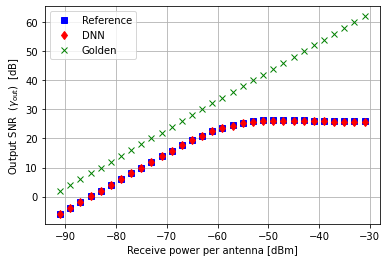

In [7]:
# Use the NN to predict the new data
pred = model(scale_in.transform(X)).numpy()

# Find the complex data
pred = pred[:, :16] + 1j * pred[:, 16:]
pred = pred.reshape(nx, nsnr, nrx)

# Baseline data
base = y_rffe.reshape(nx, nsnr, nrx)

# Baseline data
gold = y_ant.reshape(nx, nsnr, nrx)

pred_snr = np.zeros(nsnr)
base_snr = np.zeros(nsnr)
gold_snr = np.zeros(nsnr)

for isnr in range(nsnr):
    pred_snr[isnr] = snr(pred[:, isnr, :])
    base_snr[isnr] = snr(base[:, isnr, :])
    gold_snr[isnr] = snr(gold[:, isnr, :])

plt.plot(power_in, base_snr, 'bs')
plt.plot(power_in, pred_snr, 'rd')
plt.plot(power_in, gold_snr, 'gx')
plt.grid()
plt.xlabel('Receive power per antenna [dBm]')
plt.ylabel('Output SNR $\;(\gamma_\mathrm{out})\;$ [dB]')
plt.legend(['Reference', 'DNN', 'Golden'])